# 기계 번역이 걸어온 길

학습 목표
- 번역 모델이 발전해 온 과정을 살펴본다.
- 번역을 생성하는 여러 가지 방법을 이해한다.
- 주어진 데이터로 더 높은 성능을 만들어 내는 법을 배운다.
- 자연어 처리의 성능을 측정하기 위한 지표를 배운다.

## 번역의 흐름

규칙 기반 기계 번역 (RMBT, Rule-Based Machine Translation)
- https://m.blog.naver.com/newheater/221763031420 참고

통계적 기계 번역 (SMT, Statistical Machine Translation)
- https://wikidocs.net/21687 참고
- P(는|나) = 0.9, P(커피|나는) = 0.5, P(밥|나는) = 0.3, P(를|나는 커피) = 0.95, P(마신다|나는 커피를) = 0.73, P(먹는다|나는 밥을) = 0.81 이 경우 "나는 커피를 마신다" 에 대한 확률은?
  - 는|나 * 커피|나는 * 를|나는 커피 * 마신다|나는 커피를 = 0.9 * 0.5 * 0.95 * 0.73 = 0.312075
- 장점:
  - 일일이 규칙을 정의해야 하는 규칙 기반 모델보다 개발에 대한 Cost가 훨씬 적다.
  - 많은 데이터가 뒷받침될 경우, 훨씬 더 유연한 문장 생성이 가능하다(많이 사용되는 문장).
- 한계점:
  - 본 적이 없는 문장에 대한 모델링이 불가능하다. 즉 데이터 의존적이다.
  - 문장의 어순에 대한 고려가 없기 때문에 다소 어색한 문장이 생성될 수 있다.

"문장이 존재할 확률을 측정한다." 뭔가 멋진 개념을 담은 언어 모델이죠?  
통계적 언어 모델을 활용한 SMT는 과연 어떻게 동작하는 걸까요?  
번역은 자연스러운 문장을 생성하는 것뿐만 아니라 번역문의 문법 구조도 고려해야 하기 때문에 단순히 P(Target | Source) 만을 고려해서는 안 된답니다. 원문과 번역문, 각 단어 간의 매핑 관계를 추가로 고려해야 하는데, 그 관계를 정렬(Alignment) 이라고 부릅니다.

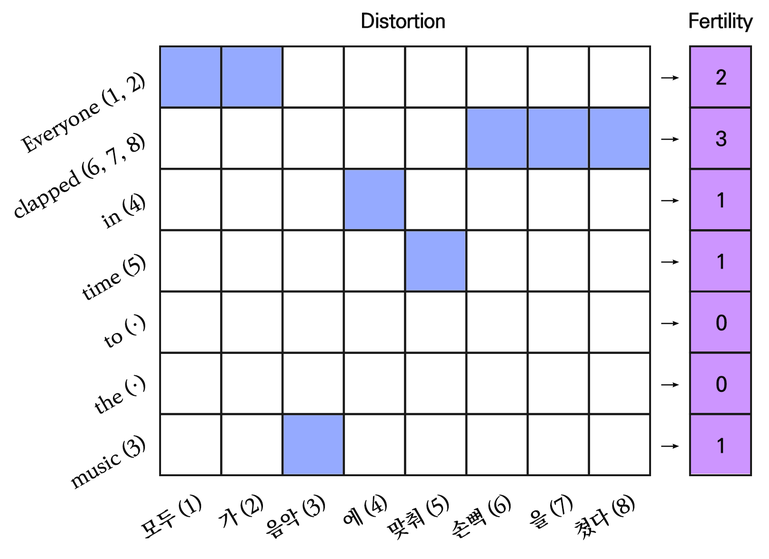

In [1]:
from IPython.display import Image
Image(filename='capture/16_align.png') 

정렬(Alignment)에는 Distortion(왜곡)과 Fertility(퍼틸리티)가 포함됩니다.

퍼틸리티(Fertility)
- 직역하면 "출생률" 정도 되는 뜬금없는 의미를 갖고 있다.
- 원문의 각 단어가 번역 후에 몇 개의 단어로 나타나는지를 의미하는 값
- 위 예를 따르면
  - Everyone 의 퍼틸리티는 2 이고, clapped 는 3 이다. to, the 는 0 이다. 즉, 번역에 직접적으로 등장하지 않는다는 의미.
  - 퍼틸리티에 대한 확률은 p(n|w) 로 정의되며, n은 퍼틸리티 값, w는 원문의 단어
  - music 은 높은 확률로 음악 으로만 번역될 테니 p(1|music)=0.9 정도로 표현할 수 있겠다.

왜곡(Distortion)
- 원문의 단어가 번역문에서 존재하는 위치를 나타냅니다.
- 위 예를 따르면
  - clapped 는 손뼉(6) 을(7) 쳤다(8) 로 번역되므로 clapped 의 왜곡은 (6,7,8) 로 나타난다.
- 왜곡에 대한 확률은 p(t|s, l)로 정의되며
  - t는 번역문에서 각 단어의 위치
  - s는 원문에서 각 단어의 위치
  - l은 번역문의 길이
- Everyone(1) 으로 시작하는 문장은 모두(1) / 가(2) 라고 번역될 확률이 높으니 p(1|1, 8) x p(2|1, 8) 역시 제법 높을 것을 추측할 수 있다.

통계적 언어 모델에서 파생된 확류에 위 모든 확률을 곱하여 학습하는 것이 바로 <b>통계적 기계 번역</b> 입니다.

E: Everyone(1, 2) clapped(6, 7, 8) in(4) time(5) to(·) the(·) music(3)  
-> K: 모두(1) 가(2) 음악(3) 에(4) 맞춰(5) 손뼉(6) 을(7) 쳤다(8)

	p(E|K) =
	{p(2|Everyone) x p(1|1, 8) x p(2|1, 8) x p(모두|Everyone) x p(가|Everyone)} x
	{p(3|clapped) x p(6|2, 8) x p(7|2, 8) x p(8|2, 8) x p(손뼉|clapped) x p(을|clapped) x p(쳤다|clapped)} x
	{p(1|in) x p(4|3, 8) x p(에|in)} x
	{p(1|time) x p(5|4, 8) x p(맞춰|time)} x
	{p(0|to) x} x
	{p(0|the) x} x
	{p(1|music) x p(3|7, 8) x p(음악|music)}

## 신경망 기계 번역

신경망 기계 번역(Neural Machine Translation)

### 지적 생성을 위한 넓고 얕은 탐색 (1) Greedy Decoding

In [3]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)

    end_token = tokenizer.word_index["<end>"]

    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]

        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

이 함수는 훈련시킨 모델이 문장을 생성할 수 있게 해주는 함수입니다. 

우리가 주목해야 하는 부분은 바로 단어를 결정하는 부분입니다!

predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]

모델이 예측한 predict 값을 Softmax를 통해 확률값으로 변환한 후, 가장 높은 확률을 갖는 단어가 다음 단어로 결정되는 순간이죠!

아주 직관적인 개념이기에 별다른 언급이 없이 "음~ 그렇구나~" 하고 넘어갔지만,  
이는 엄연히 탐욕 알고리즘(Greedy Algorithm) 이 사용된 거랍니다.

탐욕적인 방법으로 문장을 Decoding 하니 기계 번역에서는 이를 Greedy Decoding이라고 칭합니다.

Greedy Algorithm 은 https://janghw.tistory.com/entry/%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98-Greedy-Algorithm-%ED%83%90%EC%9A%95-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98 참고

탐욕적인 방법은 효율적이지만 최적의 해를 구해준다는 보장이 없습니다.  
즉 우리는 지금 최고의 번역을 생성하고 있는 것이 아닌 거죠! 최고의 확률을 갖는 단어가 최고의 번역이 아니라는 것은 조금 와닿지 않으실 수도 있습니다. 

아래 예제로 자세하게 이해해 봅시다.

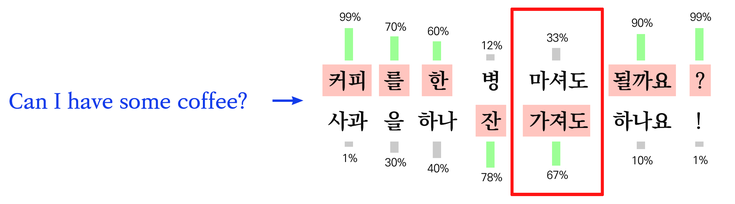

In [5]:
from IPython.display import Image
Image(filename='capture/16_greedy_algorithm.png') 

훈련 데이터가 실제 세계의 모든 데이터를 포함할 수는 없기 때문에, have 가 마시다 로 사용되는 경우가 훈련 데이터에 적거나 없었다면 탐욕적인 방법은 have 를 가장 높은 확률을 갖는 가지다 로 번역할 수밖에 없었을 겁니다.

실제 세계에서는 높은 확률로 존재하는 문장이지만 훈련 데이터 세계에서는 커피를 가지는 게 더 타당하다는 거죠!

이를 어떻게 해결할 수 있을까요? 

단어 사전으로 만들 수 있는 모든 문장을 만든 후, 실제 세계에 존재하는 우리가 직접 고르는 방법은 어떤가요?  
확실히 가장 멋진 문장을 골라낼 수는 있을 것 같습니다.  
1,000개의 단어를 갖는 사전으로 3개 단어 문장 하나를 만드는 데에 1,000,000,000개 문장이 서비스로 온다는 것은 조금 문제일 수도 있지만요!

### 지적 생성을 위한 넓고 얕은 탐색 (2) Beam Search

모든 문장을 다 만들어보는 것은 O(V^L) 의 복잡도를 갖는다는 것을 제외하곤 좋은 방법이긴 합니다.  
그런데 효율성 측면에서 문제가 있으니, 그 부분을 개선하면 되지 않을까요?

Beam Search 는 그런 아이디어에서 출발한 알고리즘입니다.  
단어 사전으로 만들 수 있는 모든 문장을 만드는 대신, 지금 상황에서 가장 높은 확률을 갖는 Top-k 문장만 남기는 거죠! 앞서 사용한 예문을 다시 빌려와 볼까요?

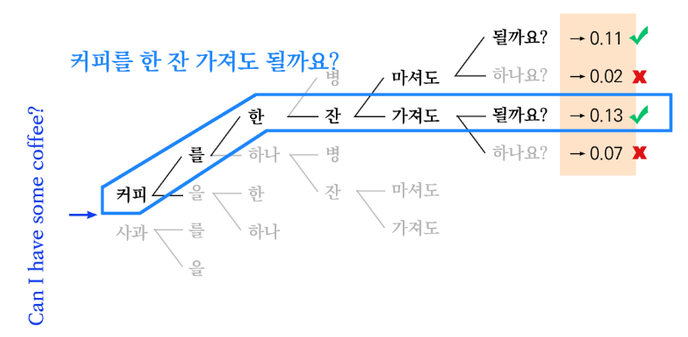

In [6]:
from IPython.display import Image
Image(filename='capture/16_beam_search.png') 

상위 몇 개의 문장을 기억할지는 Beam Size(혹은 Beam Width라고 함)로 정의해 줄 수 있습니다. 

위 예시는 Beam Size를 2로 하는 Beam Search를 표현한 것이죠. 

Beam Size는 연산량과 성능 간의 Trade-off 관계를 가지고 있습니다.  
다시 말해, 자원이 무한하다면 Beam Size를 키우면 키울수록 성능이 좋아진다는 겁니다.  
직접 실험을 통해 찾아보는 것이 좋으나 대체로 5 나 10 을 적합한 값으로 택하곤 합니다.

In [7]:
import math
import numpy as np

def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  # 생성된 문장과 점수를 저장

    for tok in prob:
        all_candidates = []

        for seq, score in sequences:
            for idx, p in enumerate(tok): # 각 단어의 확률을 총점에 누적 곱
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates,
                         key=lambda tup:tup[1],
                         reverse=True) # 총점 순 정렬
        sequences = ordered[:beam_size] # Beam Size에 해당하는 문장만 저장 

    return sequences

In [8]:
vocab = {
    0: "<pad>",
    1: "까요?",
    2: "커피",
    3: "마셔",
    4: "가져",
    5: "될",
    6: "를",
    7: "한",
    8: "잔",
    9: "도",
}

prob_seq = [[0.01, 0.01, 0.60, 0.32, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.75, 0.01, 0.01, 0.17],
            [0.01, 0.01, 0.01, 0.35, 0.48, 0.10, 0.01, 0.01, 0.01, 0.01],
            [0.24, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.68],
            [0.01, 0.01, 0.12, 0.01, 0.01, 0.80, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.81, 0.01, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01],
            [0.70, 0.22, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]

prob_seq = np.array(prob_seq)
beam_size = 3

result = beam_search_decoder(prob_seq, beam_size)

for seq, score in result:
    sentence = ""

    for word in seq:
        sentence += vocab[word] + " "

    print(sentence, "// Score: %.4f" % score)

커피 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 42.5243
커피 를 마셔 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 28.0135
마셔 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 17.8983


훈련 데이터 세계에서는 커피 를 마셔 라고도 부르나 보네요(😂😂). 

우리가 확인하고자 했던 커피를 마셔도 될까요? 에 더하여 마셔를 가져도 될까요? 까지 확인할 수 있었습니다. 굳이 고정된 개수의 문장을 얻지 않아도 된다면 적당한 Beam Size를 설정해 준 후 Score를 기준으로 필터링하는 방법도 좋겠죠?

Beam Search는 사람이 직접 좋은 번역을 고를 수 있게 상위 K개의 결과를 보여줄 뿐이라서 학습에 직접적으로 적용할 수는 없습니다. 

모델 입장에서는 뭐가 좋은 번역인지 알 수 없으니까요! 즉 모델 학습 단계에서 Beam Search를 사용하지는 않습니다.

### 지적 생성을 위한 넓고 얕은 탐색 (3) Sampling

어떻게 하면 매번 새로우며 의미가 유지되는 문장을 만들 수 있을까요?  
지금까지 확률을 기준으로 단어를 선택해왔으니, 확률적으로 단어를 뽑는 방법은 어떨까요?

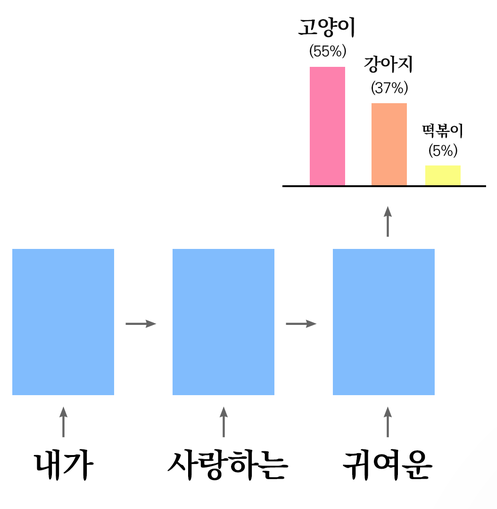

In [9]:
from IPython.display import Image
Image(filename='capture/16_sampling.png') 

Sampling은 그 아이디어를 기반으로 제안된 방법입니다. 

언어 모델은 반복적으로 다음 단어에 대한 확률 분포를 생성하기 때문에 그 확률 분포를 기반으로 랜덤하게 단어를 뽑아 보자는 거죠.  
위 예시를 따라서 100문장을 만들면 이상적인 경우 55개의 내가 사랑하는 귀여운 고양이, 37개의 내가 사랑하는 귀여운 강아지... 와 같이 문장이 생성되는 겁니다. 높은 확률을 갖는 단어를 택하는 경우가 가장 많기 때문에 랜덤이지만 지나치게 뜬금없는 문장이 생성되지는 않겠죠?

Sampling은 간혹 정말 난해한 문장을 생성할 수도 있기 때문에 실제 서비스에서는 거의 사용되지 않습니다. 

## 방과 후 번역 수업 (1) Data Augmentation

모델을 훈련시키는 법을 배웠고, 훈련된 모델이 문장을 생성하게 하는 법도 3가지나 배웠습니다!.  
이 모든 것들이 정규 수업이었다면, 지금부터 배울 것은 방과 후 보충수업이랄까요?

Data Augmentation은 '데이터 증가', '데이터 확대' 등으로 직역되며 훈련 데이터를 수십 배까지도 부풀리는 기술을 의미합니다!  
https://nittaku.tistory.com/272 참고

## 방과 후 번역 수업 (2) Lexical Substitution

Lexical Substitution은 '어휘 대체'로 직역됩니다.  
대체할 어휘를 선정하는 기준에 따라서 기법이 세부적으로 나뉘는데, 총 3가지를 배워보도록 하죠!

### 동의어 기반 대체

시소러스(Thesaurus) 란, 어떤 단어의 동의어나 유의어를 집중적으로 구축해놓은 사전을 의미합니다.  
동의어 기반 대체는 이 시소러스를 활용한 방법입니다. 대표적인 시소러스인 워드넷(WordNet) 을 잘 다룬 글을 첨부합니다!.    
https://kh-kim.gitbook.io/natural-language-processing-with-pytorch/00-cover-4/03-wordnet 참고

### Embedding 활용 대체

Pre-training Word Embedding을 활용하는 방법이 바로 그것입니다.  
우리는 이미 Word2Vec이나 GloVe 등의 기법들을 배웠죠. 이 기법들을 통해 학습된 Embedding은 유사한 단어들끼리 비슷한 공간에 밀집되던 것을 기억하실 겁니다. 사람이 일일이 정의한 데이터베이스 대신, 이 Embedding의 유사도를 기반으로 단어를 대체하면 훨씬 편리하겠죠!

### TF-IDF 기반 대체

TF-IDF는 여러 문서를 기반으로 단어마다 중요도를 부여하는 알고리즘입니다.  
문서의 핵심이 되는 소년, 피리 같은 단어들은 높은 TF-IDF 값을 부여받고, 한, 를과 같은 단어들은 낮은 TF-IDF 값을 가지게 됩니다.  
이때, 낮은 TF-IDF 값을 갖는 단어들은 핵심 단어가 아니기 때문에 다른 단어로 대체해도 문맥이 크게 변하지 않는다는 것에 주목한 아이디어입니다.

## 방과 후 번역 수업 (3) Back Translation

Back Translation은 단일 언어 데이터는 구하기 쉽고 많지만 병렬 쌍을 이룬 언어 데이터를 찾기는 어렵다는 문제를 해결하고자 등장했습니다.  
번역 모델에 단일 언어 데이터를 학습시키는 방법이죠!

Sequence-to-Sequence의 구조를 되새겨보면, Source 문장을 Encoding 하는 부분과 Target 문장을 Decoding 하는 부분을 분리하여 모듈들이 각 언어를 더 잘 처리할 수 있게 했었습니다.  
그렇다면 Encoder에는 Source 언어로 된 문장을, Decoder에는 Target 언어로 된 문장을 좀 더 훈련시키면 어떨까요?  
더 자세한 내용은 아래 웹페이지에서 살펴보세요!.   
https://dev-sngwn.github.io/2020-01-07-back-translation/

## 방과 후 번역 수업 (4) Random Noise Injection

데이터에 포함된 적당한 노이즈는 때때로 학습에 도움이 되기도 합니다.  
그런 의미에서 문장에 노이즈를 주는 것도 괜찮은 Augmentation 기법이 될 수 있겠죠! 이 또한 노이즈를 주는 기준에 따라서 방법이 여러 가지로 나뉘는데, 간단하게 3가지 정도만 알아봅시다.

### 오타 노이즈 추가

이를 이용한 Augmentation 기법이 바로 오타 노이즈를 추가하는 것이죠!

### 공백 노이즈 추가

엄연히 말하면 완벽한 공백이 아니고, _ 토큰을 활용하며 이를 Placeholder Token(이하 공백 토큰) 이라고 부릅니다.  
문장의 일부 단어를 공백 토큰으로 치환하는데요, 학습의 과적합을 방지하는 데에 좋은 효과를 볼 수 있다고 합니다.

### 랜덤 노이즈 추가

주어진 문장에서 불용어(Stop word)가 아닌 단어를 랜덤하게 뽑은 후, 해당 단어와 유사한 단어를 골라 문장에 아무렇게나 삽입하는 방식입니다.

앞서 배운 Lexical Substitution과 비슷한 느낌이지만 원본 단어가 손실되지 않는다는 것이 조금 더 매력적이죠? Word2Vec의 아이디어를 생각하면 유사어를 삽입하는 것이 모델의 Embedding 층을 더 견고하게 만들어 줄 것 같네요!

## 채첨은 어떻게?

번역의 품질을 쉽고 빠르게 평가할 수 있는 객관적인 지표가 필요합니다.

<b>BLEU(Bilingual Evaluation Understudy) Score</b>는 이에 발맞춰 등장한 번역 평가 지표입니다.  
https://donghwa-kim.github.io/BLEU.html 참고


기계 번역은 BLEU Score로 줄 세우기가 가능하다는 것을 알았습니다.  
혹시 다른 Task에 대한 평가 지표도 궁금하지 않으신가요? 

자연어 이해(Natural Language Understanding)에 관련된 최신 논문을 본 적이 있으시다면 GLUE 라는 것을 보셨을 거예요.  
GLUE는 기계 번역 너머의 자연어 이해를 평가하기 위해 고안된 지표입니다.  
지금은 자세한 내용보다 가볍게 읽기 좋은 글을 첨부하고 넘어갈게요!.   
https://huffon.github.io/2019/11/16/glue/

## 실례지만, 어디 챗씨입니까? (1) 챗봇과 번역기

조금 뜬금없지만 챗봇과 번역기는 같은 집안이랍니다!.   
본격적인 챗봇 얘기에 들어가기에 앞서, 개괄적으로 챗봇의 이모저모를 다룬 좋은 글을 하나 읽도록 하죠!

챗봇을 위한 딥러닝 1. 개요 -> https://norux.me/56 참고

챗봇도 만드는 방법에 따라 두 가지로 나뉘는데요, 각각은
- 검색기반 모델
- 생성 모델

Open Domain과 Closed Domain의 차이점
- 열린 도메인Open Domain(어려움) 유저는 아무렇게나 대화를 할 수 있습니다. 이것은 목표나 의도가 잘 정의되지 않아도 된다는 의미입니다. 
- 닫힌 도메인Closed Domain(쉬움) 시스템은 특정한 목표만을 수행하기 때문에 인풋과 아웃풋이 다소 제한적입니다. 고객 지원이나 쇼핑 어시스트들이 닫힌 도메인Closed Domain에 해당합니다. 

## 실례지만, 어디 챗씨입니까? (2) 좋은 챗봇이 되려면

대신 신경 써야 할 부분이 몇 가지 있습니다. 대표적인 4가지만 알아볼까요?

200ms
- 대화가 자연스럽게 느껴지는 답변의 공백 마지노선
- 인간이 챗봇한테 말을 걸었을 때, 0.2초 이내에 답변이 나오는 것이 바람직하다는 거죠! 스마트폰에 탑재된 인공지능 비서는 가장 단순하게 생각해도 음성 인식, 답변 추론, 음성 생성까지 해야 하는데 0.2초면 제법 가혹하죠?
- 실제로는 10개 이상의 모듈이 동작하기 때문에 각 모듈에 0.01초 수준의 시간이 주어진다고 합니다. 우리, 조금만 더 관대해지도록 해요.

시공간을 담은 질문
- 거창한 제목이지만, 사실은 오늘 무슨 요일이야? 를 말하는 겁니다. 앞서 배운 것처럼 질문이 고유한 답변을 가진다면 챗봇이 학습하기 좋지만 요일을 묻는 질문은 매일 답변이 변하니 학습을 할 수가 없겠죠?
- 그래서 보통은 질문의 의도를 파악한 후, 시공간에 대한 질문은 다른 모듈로 연결하여 예외 처리를 하곤 한답니다. 

페르소나
- 인격의 일관성
- 학습에는 주로 많은 사람들의 채팅 데이터를 모아서 사용할 수밖에 없기 때문에 모델이 대답의 일관성을 갖는다는 것은 굉장히 도전적이죠.
- 이때의 일관성을 모델의 인격이라고 칭하며, 그것을 페르소나라고 부릅니다. 
- https://doc.danbee.ai/blog_005_UX04_persona.html 참고
  - 페르소나는 제품이나 서비스 목적에 맞게 설정되어야합니다. 목적, 개성이 나타날 수 있는 요소(성격, 목표, 동기부여, 니즈 등)
  
대화의 일관성
- 아직까지 사용자에 관한 정보를 기억하고 이를 활용하는 모델은 없어요. 대신 너무 뜬금없는 대답을 막아서 대화의 일관성을 유지하려는 시도는 있었죠. 


## 실례지만, 어디 챗씨입니까? (3) 대표적인 챗봇

Meena
- 구글이 만든 챗봇
- 거대하기로 빼놓으면 섭섭한 GPT-2보다 2배가량 큰 모델을 9배 더 많은 데이터로 학습한 친구예요! 
- 모델 구조는 Evolved Transformer를 사용했답니다.
- 무엇보다 자체적인 대화 평가 지표인 SSA를 제안하고 이를 분석한 부분이 굉장히 인상적이에요.
- https://brunch.co.kr/@synabreu/35 참고
  - 새로운 인간 평가 메트릭인 Sensibleness and Specificity Average (SSA)를 설계함

Blender
- 이후에 등장한 Facebook의 Blender도 못지않게 멋진 녀석입니다! 
- 모델에 페르소나를 부여하고자 하는 시도와 자체적인 평가 지표 ACUTE-Eval을 제안한 것이 인상적이죠. 
- https://littlefoxdiary.tistory.com/39 참고